In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline


Quantum models as Fourier series
============================




This demonstration is based on the paper *The effect of data encoding on
the expressive power of variational quantum machine learning models* by
[Schuld, Sweke and Meyer
(2020)](https://arxiv.org/abs/2008.08605) [1].

<img src="figures/scheme_thumb.png" alt="scheme" width="500" />

The paper links common quantum machine learning models designed for
near-term quantum computers to Fourier series (and, in more general, to
Fourier-type sums). With this link, the class of functions a quantum
model can learn (i.e., its "expressivity") can be characterised by the
model's control of the Fourier series' frequencies and coefficients.




## Background


Ref. [1] considers quantum machine
learning models of the form

\begin{align}f_{\boldsymbol \theta}(x) = \langle 0| U^{\dagger}(x,\boldsymbol \theta) M U(x, \boldsymbol \theta) | 0 \rangle\end{align}

where $M$ is a measurement observable and
$U(x, \boldsymbol \theta)$ is a variational quantum circuit that
encodes a data input $x$ and depends on a
set of parameters $\boldsymbol \theta$. Here we will restrict ourselves
to one-dimensional data inputs, but the paper motivates that higher-dimensional
features simply generalise to multi-dimensional Fourier series.

The circuit itself repeats $L$ layers, each consisting of a data encoding circuit
block $S(x)$ and a trainable circuit block
$W(\boldsymbol \theta)$ that is controlled by the parameters
$\boldsymbol \theta$. The data encoding block consists of gates of
the form $\mathcal{G}(x) = e^{-ix H}$, where $H$ is a
Hamiltonian. A prominent example of such gates are Pauli rotations.




The paper shows how such a quantum model can be written as a
Fourier-type sum of the form

\begin{align}f_{ \boldsymbol \theta}(x) = \sum_{\omega \in \Omega} c_{\omega}( \boldsymbol \theta) \; e^{i  \omega x}.\end{align}

As illustrated in the picture below (which is Figure 1 from the paper),
the "encoding Hamiltonians" in $S(x)$ determine the set
$\Omega$ of available "frequencies", and the remainder of the
circuit, including the trainable parameters, determine the coefficients
$c_{\omega}$.




<img src="figures/scheme.png" alt="scheme" width="500" />




The paper demonstrates many of its findings for circuits in which
$\mathcal{G}(x)$ is a single-qubit Pauli rotation gate. For
example, it shows that $r$ repetitions of a Pauli rotation
encoding gate in "sequence" (on the same qubit, but with multiple layers $r=L$) or
in "parallel" (on $r$ different qubits, with $L=1$) creates a quantum
model that can be expressed as a *Fourier series* of the form

\begin{align}f_{ \boldsymbol \theta}(x) = \sum_{n \in \Omega} c_{n}(\boldsymbol \theta) e^{i  n x},\end{align}

where $\Omega = \{ -r, \dots, -1, 0, 1, \dots, r\}$ is a spectrum
of consecutive integer-valued frequencies up to degree $r$.

As a result, we expect quantum models that encode an input $x$ by
$r$ Pauli rotations to only be able to fit Fourier series of at
most degree $r$.




## Goal of this demonstration





The experiments below investigate this "Fourier-series"-like nature of
quantum models by showing how to reproduce the simulations underlying
Figures 3, 4 and 5 in Section II of the paper:

-  **Figures 3 and 4** are function fitting experiments, where quantum
   models with different encoding strategies have the task to fit
   Fourier series up to a certain degree. As in the paper, we will use
   examples of qubit-based quantum circuits where a single data feature
   is encoded via Pauli rotations.

-  **Figure 5** plots the Fourier coefficients of randomly sampled
   instances from a family of quantum models which is defined by some
   parametrised ansatz.

The code is presented so you can easily modify it in order to play
around with other settings and models. The settings used in the paper 
are given in the various subsections.




## Imports and global functions





First of all, let's make some imports and define a standard loss
function for the training.




In [2]:
!pip install pennylane

In [3]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np

np.random.seed(42)

def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss = loss + (t - p) ** 2
    loss = loss / len(targets)
    return 0.5*loss

# Part I: Fitting Fourier series with serial Pauli-rotation encoding





First we will reproduce Figures 3 and 4 from the paper. These
show how quantum models that use Pauli rotations as data
encoding gates can only fit Fourier series up to a certain degree. The
degree corresponds to the number of times that the Pauli gate gets
repeated in the quantum model.

First, let us consider circuits where a the encoding gate gets repeated
sequentially (as in Figure 2a of the paper). For simplicity we will only
look at single qubit circuits:

<img src="figures/single_qubit_model.png" alt="single_qubit_model" width="500" />




## Define a target function

We first define a (classical) target function which will be used as a 
"ground truth" that the quantum model has to fit. The target function is 
constructed as a Fourier series of a specific degree. 

We also allow for a rescaling of the data by a hyperparameter ``scaling``, 
which we will do in the quantum model as well. As shown in [1], for the quantum model to 
learn the classical model in the experiment below,
the scaling of the quantum model and the target function have to match, 
which is an important observation for 
the design of quantum machine learning models.





In [4]:
degree = 1 # degree of the target function
scaling = 1 # scaling of the data
coeffs = [0.15 + 0.15j]*degree # coefficients of non-zero frequencies
coeff0 = 0.1 # coefficient of zero frequency

def target_function(x):
    """Generate a truncated Fourier series of degree, where the data gets re-scaled."""
    res = coeff0
    for idx, coeff in enumerate(coeffs):
        exponent = complex(0, scaling*(idx+1)*x)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res)

Let's have a look at it.




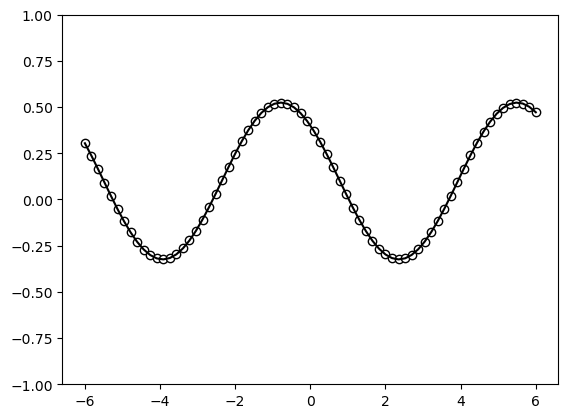

In [5]:
x = np.linspace(-6, 6, 70)
target_y = np.array([target_function(x_) for x_ in x])

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-1, 1)
plt.show()

<div class="alert alert-info"><h4>Note</h4><p>To reproduce the figures in the paper, you can use the following
    settings in the cells above:

-  For the settings

       degree = 1
       coeffs = [0.15 + 0.15j]*degree 
       coeff0 = 0.1

   this function is the ground truth
   $g(x) = \sum_{n=-1}^1 c_{n} e^{-nix}$ from Figure 3 in the
   paper.

-  To get the ground truth $g'(x) = \sum_{n=-2}^2 c_{n} e^{-nix}$
   with $c_0=0.1$ $c_1 = c_2 = 0.15 - 0.15i$ from Figure 3,
   you need to increase the degree to two:

       degree = 2

-  The ground truth from Figure 4 can be reproduced by changing the
   settings to:

       degree = 5 
       coeffs = [0.05 + 0.05j]*degree 
       coeff0 = 0.0
</p>
</div>




## Define the serial quantum model





We now define the quantum model itself.




In [6]:
scaling = 1  # Make sure scaling is defined

# Define the quantum device
dev = qml.device('default.qubit', wires=1)

# Data encoding block S
def S(x):
    """Data encoding circuit block."""
    if x is None:
        raise ValueError("x cannot be None, please pass a valid input for x.")
    qml.RX(scaling * x, wires=0)

# Trainable block W
def W(theta):
    """Trainable circuit block."""
    qml.Rot(theta[0], theta[1], theta[2], wires=0)

# Quantum model
@qml.qnode(dev)
def serial_quantum_model(weights, x):
    for theta in weights[:-1]:
        W(theta)
        S(x)
        
    # Last unitary (L+1'th)
    W(weights[-1])
    
    # Return expectation value
    return qml.expval(qml.PauliZ(wires=0))

You can run the following cell multiple times, each time sampling
different weights, and therefore different quantum models.




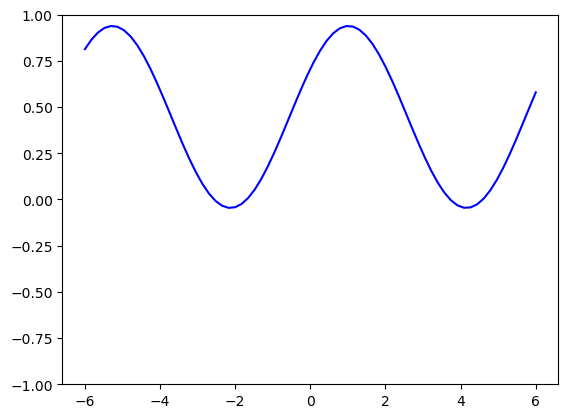

In [7]:
r = 1 # number of times the encoding gets repeated (here equal to the number of layers)
weights = 2*np.pi*np.random.random(size=(r+1, 3)) # some random initial weights

x = np.linspace(-6, 6, 70)
random_quantum_model_y = [serial_quantum_model(weights, x=x_) for x_ in x]

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show()

No matter what weights are picked, the single qubit model for `L=1` will always be a sine function 
of a fixed frequency. The weights merely influence the amplitude, y-shift and phase of the sine.

This observation is formally derived in Section II.A of the paper.




<div class="alert alert-info"><h4>Note</h4><p>You can increase the number of layers. Figure 4 from the paper, for
    example, uses the settings <code>L=1</code>, <code>L=3</code> and <code>L=5</code>.
</p></div>




Finally, let's look at the circuit we just created:




In [8]:
# print(serial_quantum_model.draw())
# print(qml.draw(serial_quantum_model)(weights))

# Example usage
weights = 2 * np.pi * np.random.random(size=(3, 3))  # Random weights
x_value = np.random.random()  # Random value for x

# Draw the quantum circuit with the given weights and x_value
print(qml.draw(serial_quantum_model)(weights, x_value))

0: ──Rot(2.10,0.90,4.09)──RX(0.61)──Rot(0.35,4.54,5.90)──RX(0.61)──Rot(0.00,6.23,3.88)─┤  <Z>


## Fit the model to the target



The next step is to optimise the weights in order to fit the ground
truth.




In [9]:
def cost(weights, x, y):
    predictions = [serial_quantum_model(weights, x=x_) for x_ in x]
    return square_loss(y, predictions)

max_steps = 60
opt = qml.AdamOptimizer(0.3)
batch_size = 25
cst = [cost(weights, x, target_y)]  # initial cost

for step in range(max_steps):

    # Select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    # Update the weights by one optimizer step
    weights = opt.step(lambda w: cost(w, x_batch, y_batch), weights)

    # Save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

Cost at step  10: 0.0013597029888980667
Cost at step  20: 0.007080331170932298
Cost at step  30: 0.0054405472410752114
Cost at step  40: 0.0008687366570643955
Cost at step  50: 0.0014355134217330487
Cost at step  60: 0.0014673879445603391


To continue training, you may just run the above cell again. Once you
are happy, you can use the trained model to predict function values, and
compare them with the ground truth.




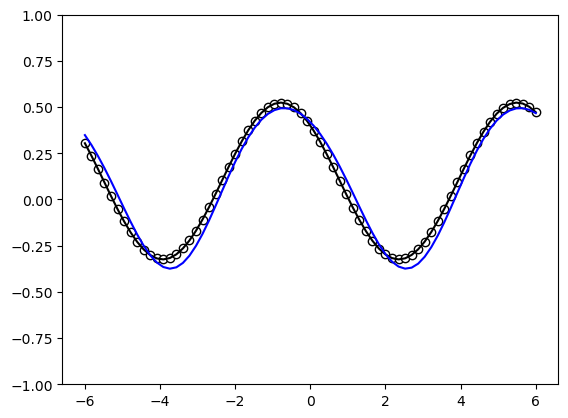

In [10]:
predictions = [serial_quantum_model(weights, x=x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue')
plt.ylim(-1,1)
plt.show()

Let's also have a look at the cost during training.




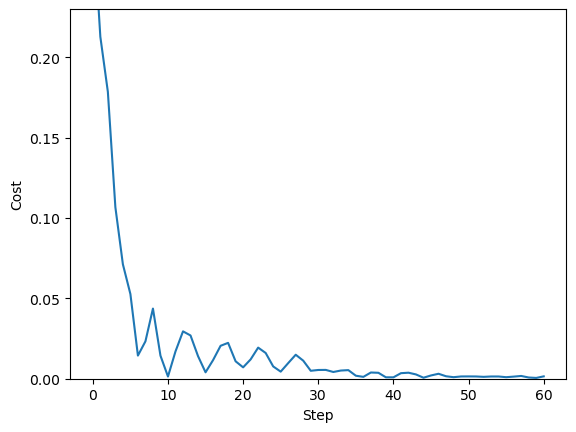

In [11]:
plt.plot(range(len(cst)), cst)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.ylim(0, 0.23)
plt.show()

With the initial settings and enough training steps, the quantum model 
learns to fit the ground truth perfectly. This is expected, since 
the number of Pauli rotation encoding gates and the degree of the 
ground truth Fourier series are both one.

If the ground truth's degree is larger than the number of layers in the
quantum model, the fit will look much less accurate. And finally, we
also need to have the correct scaling of the data: if one of the models
changes the ``scaling`` parameter (which effectively scales the
frequencies), fitting does not work even with enough encoding
repetitions.




<div class="alert alert-info"><h4>Note</h4>
    <p>
    You will find that the training takes much longer, and needs a lot more steps to converge for 
    larger L. Some initial weights may not even converge to a good solution at all, the training 
    seems to get stuck in a minimum. It is an open research question whether for asymptotically large L, 
    the single qubit model can fit <i>any</i> function by constructing arbitrary Fourier coefficients.
    
</p>
</div>




# Part II: Fitting Fourier series with parallel Pauli-rotation encoding





Our next task is to repeat the function fitting experiment for a circuit
where the Pauli rotation gate gets repeated $r$ times on
*different* qubits, using a single layer $L=1$.

As shown in the paper, we expect similar results to the serial model: a
Fourier series of degree $r$ can only be fitted if there are at
least $r$ repetitions of the encoding gate in the quantum model.
However, in practice this experiment is a bit harder, since the dimension of the
trainable unitaries $W$ grows quickly with the number of qubits.

In the paper, the investigations are made with the assumption that the
purple trainable blocks $W$ are arbitrary unitaries. We could use
the ``pennylane.templates.ArbitraryUnitary`` template, but since this
template requires a number of parameters that grows exponentially with
the number of qubits ($4^L-1$ to be precise), this quickly becomes
cumbersome to train.

We therefore follow Figure 4 in the paper and use an ansatz for
$W$. 





<img src="figures/parallel_model.png" alt="parallel_model" width="600" />





## Define the parallel quantum model





The ansatz is PennyLane's layer structure called
``StronglyEntanglingLayers``, and as the name suggests, it has itself a
user-defined number of layers (which we will call "ansatz layers" to
avoid confusion).




In [12]:
from pennylane.templates import StronglyEntanglingLayers

Let's have a quick look at the ansatz itself for 3 qubits by making a
dummy circuit of 2 ansatz layers:




In [14]:
n_ansatz_layers = 2
n_qubits = 3

dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev)
def ansatz(weights):
    StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.Identity(wires=0))

weights_ansatz = 2*np.pi*np.random.random(size=(n_ansatz_layers, n_qubits, 3))

ansatz(weights_ansatz)
print(qml.draw(ansatz)(weights_ansatz))

0: ─╭StronglyEntanglingLayers(M0)─┤  <I>
1: ─├StronglyEntanglingLayers(M0)─┤     
2: ─╰StronglyEntanglingLayers(M0)─┤     

M0 = 
[[[1.48928995 1.47450047 5.55251161]
  [2.77732105 2.07903918 2.81975266]
  [4.20590394 0.91581553 2.82387607]]

 [[3.69378644 5.960125   1.58667885]
  [2.25723902 2.38358032 3.80470846]
  [2.24141359 3.35215429 4.91213351]]]


Now we define the actual quantum model.




In [15]:
scaling = 1
r = 3

dev = qml.device('default.qubit', wires=r)

def S(x):
    """Data encoding circuit block."""
    for w in range(r):
        qml.RX(scaling*x, wires=w)

def W(theta):
    """Trainable circuit block."""
    StronglyEntanglingLayers(theta, wires=range(r))

    
@qml.qnode(dev)
def parallel_quantum_model(weights, x=None):
    
    W(weights[0])
    S(x)        
    W(weights[1])
    
    return qml.expval(qml.PauliZ(wires=0))

Again, you can sample random weights and plot the model function:




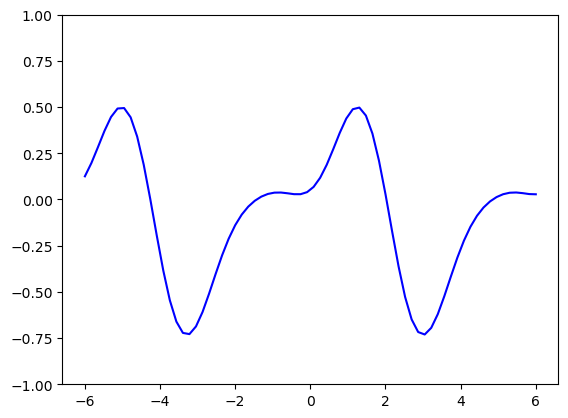

In [16]:
trainable_block_layers = 3
weights = 2*np.pi*np.random.random(size=(2, trainable_block_layers, r, 3))

x = np.linspace(-6, 6, 70)
random_quantum_model_y = [parallel_quantum_model(weights, x=x_) for x_ in x]

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show()

## Training the model




Training the model is done exactly as before, but it may take a lot
longer this time. We set a default of 25 steps, which you should
increase if necessary. Small models of <6 qubits
usually converge after a few hundred steps at most -- but this
depends on your settings.




In [17]:
def cost(weights, x, y):
    predictions = [parallel_quantum_model(weights, x=x_) for x_ in x]
    return square_loss(y, predictions)

max_steps = 60
opt = qml.AdamOptimizer(0.3)
batch_size = 25
cst = [cost(weights, x, target_y)]  # initial cost

for step in range(max_steps):

    # select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    # update the weights by one optimizer step
    weights = opt.step(lambda w: cost(w, x_batch, y_batch), weights)
    
    # save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

Cost at step  10: 0.02795908983382318
Cost at step  20: 0.005631500892107125
Cost at step  30: 0.004213776646674997
Cost at step  40: 0.003524407344558427
Cost at step  50: 0.001944525567731575
Cost at step  60: 0.0012868462548222066


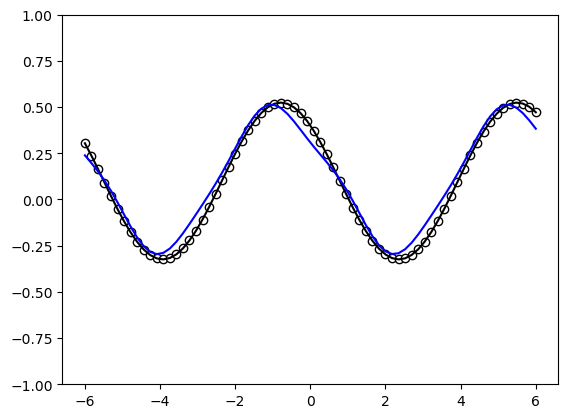

In [18]:
predictions = [parallel_quantum_model(weights, x=x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue')
plt.ylim(-1,1)
plt.show()

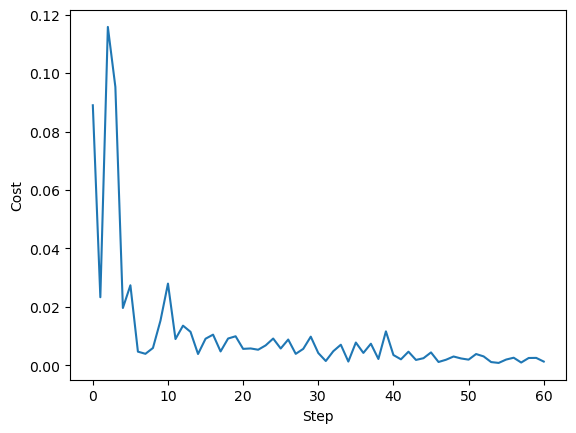

In [19]:
plt.plot(range(len(cst)), cst)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.show()

<div class="alert alert-info"><h4>Note</h4><p>To reproduce the right column in Figure 4 from the paper, use the 
    correct ground truth, $r=3$ and <code>trainable_block_layers=3</code>,
    as well as sufficiently many training steps. The amount of steps 
    depends on the initial weights and other hyperparameters, and 
    in some settings training may not converge to zero error at all.</p></div>




# Part III: Sampling Fourier coefficients





When we use a trainable ansatz above, it is possible that even with
enough repetitions of the data-encoding Pauli rotation, the quantum
model cannot fit the circuit, since the expressivity of quantum models
also depends on the Fourier coefficients the model can create.

Figure 5 in [1] shows Fourier coefficients
from quantum models sampled from a model family defined by an 
ansatz for the trainable circuit block. For this we need a
function that numerically computes the Fourier coefficients of a
periodic function f with period $2 \pi$.




In [20]:
def fourier_coefficients(f, K):
    """
    Computes the first 2*K+1 Fourier coefficients of a 2*pi periodic function.
    """
    n_coeffs = 2*K+1
    t = np.linspace(0, 2*np.pi, n_coeffs, endpoint=False)
    y = np.fft.rfft(f(t)) / t.size
    return y

## Define your quantum model


Now we need to define a quantum model. This could be any model, for example one of the quantum models from
above. We will use a slight derivation of the ``parallel_qubit_model()``
from above, this time using the ``BasicEntanglerLayers`` ansatz:




In [21]:
from pennylane.templates import BasicEntanglerLayers

scaling = 1
n_qubits = 4

dev = qml.device('default.qubit', wires=n_qubits)

def S(x):
    """Data encoding circuit block."""
    for w in range(n_qubits):
        qml.RX(scaling*x, wires=w)

def W(theta):
    """Trainable circuit block."""
    BasicEntanglerLayers(theta, wires=range(n_qubits))

    
@qml.qnode(dev)
def quantum_model(weights, x=None):
    
    W(weights[0])
    S(x)
    W(weights[1])
    
    return qml.expval(qml.PauliZ(wires=0))

It will also be handy to define a function that samples different random
weights of the correct size for the model.




In [22]:
n_ansatz_layers = 1

def random_weights():
    return 2 * np.pi * np.random.random(size=(2, n_ansatz_layers, n_qubits))

Now we can compute the first few Fourier coefficients for samples from
this model. The samples are created by randomly sampling different
parameters using the ``random_weights()`` function.




In [23]:
n_coeffs = 5
n_samples = 100


coeffs = []
for i in range(n_samples):

    weights = random_weights()

    def f(x):
        return np.array([quantum_model(weights, x=x_) for x_ in x])

    coeffs_sample = fourier_coefficients(f, n_coeffs)
    coeffs.append(coeffs_sample)

coeffs = np.array(coeffs)
coeffs_real = np.real(coeffs)
coeffs_imag = np.imag(coeffs)

Let's plot the real vs. the imaginary part of the coefficients. As a
sanity check, the $c_0$ coefficient should be real, and therefore
have no contribution on the y-axis.




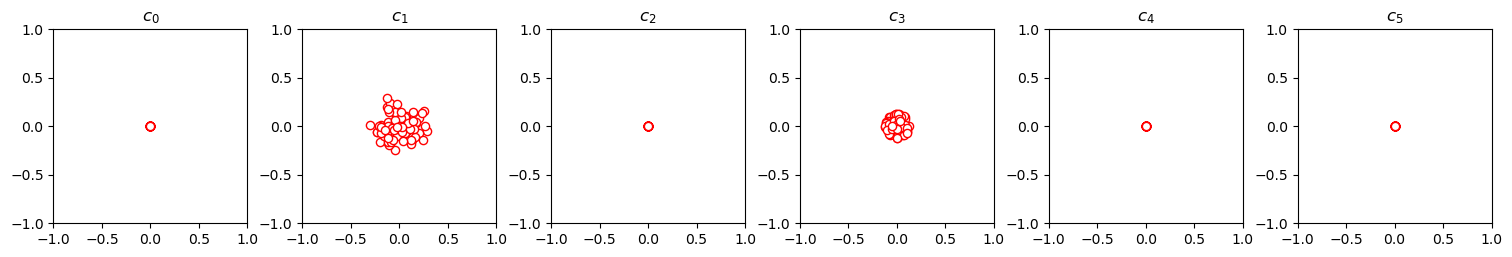

In [24]:
n_coeffs = len(coeffs_real[0])

fig, ax = plt.subplots(1, n_coeffs, figsize=(15,4))

for idx, ax_ in enumerate(ax):
    ax_.set_title(r"$c_{}$".format(idx))
    ax_.scatter(coeffs_real[:, idx], coeffs_imag[:, idx], s=35, facecolor='white', edgecolor='red')
    ax_.set_aspect("equal")
    ax_.set_ylim(-1, 1)
    ax_.set_xlim(-1, 1)


plt.tight_layout(pad=0.5)
plt.show()

Playing around with different quantum models, you will find that some quantum models create different distributions over the coefficients than others. For example ``BasicEntanglingLayers`` (with the default 
Pauli-X rotation) seems to have a structure that forces the even Fourier coefficients to zero, while ``StronglyEntanglingLayers`` will have a non-zero variance for all supported coefficients.

Note also how the variance of the distribution decreases for growing
orders of the coefficients - an effect linked to the convergence of a
Fourier series.




<div class="alert alert-info"><h4>Note</h4><p>To reproduce the results from Figure 5 you have to change the ansatz (no
    unitary, <code>BasicEntanglerLayers</code> or <code>StronglyEntanglingLayers</code>, and
    set <code>n_ansatz_layers</code> either to $1$ or $5$. The
    <code>StronglyEntanglingLayers</code> requires weights of shape
    <code>size=(2, n_ansatz_layers, n_qubits, 3)</code>.</p></div>




## Continuous-variable model


Ref. [1] mentions that a phase rotation in
continuous-variable quantum computing has a spectrum that supports *all*
Fourier frequecies. To play with this model, we finally show you the
code for a continuous-variable circuit. For example, to see its Fourier
coefficients run the cell below, and then re-run the two cells above.




In [25]:
var = 2
n_ansatz_layers = 1
dev_cv = qml.device('default.gaussian', wires=1)

def S(x):
    qml.Rotation(x, wires=0)

def W(theta):
    """Trainable circuit block."""
    for r_ in range(n_ansatz_layers):
        qml.Displacement(theta[0], theta[1], wires=0)
        qml.Squeezing(theta[2], theta[3], wires=0)

@qml.qnode(dev_cv)
def quantum_model(weights, x=None):
    W(weights[0])
    S(x)
    W(weights[1])
    return qml.expval(qml.X(wires=0))

def random_weights():
    return np.random.normal(size=(2, 5*n_ansatz_layers), loc=0, scale=var)

<div class="alert alert-info"><h4>Note</h4>
    <p>To find out what effect so-called "non-Gaussian" gates like the 
    <code>Kerr</code> gate have, you need to install the 
    <a href="https://pennylane-sf.readthedocs.io/en/latest/">strawberryfields plugin</a>
    and change the device to 
    <code>dev_cv = qml.device('strawberryfields.fock', wires=1, cutoff_dim=50)</code>.
   </p>
 </div>




References
---------------

[1] Maria Schuld, Ryan Sweke and Johannes Jakob Meyer, *The effect of data encoding on
the expressive power of variational quantum machine learning models*, arxiv preprint arxiv:2008.08605.

